In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from pathlib import Path
from eyeTrackingProcessing import IVT  # import module

In [2]:
root = Path("./")
path_to_data = root / "raw_data.csv"

df = pd.read_csv(path_to_data, sep=";")
df.shape

(65535, 4)

In [3]:
df.head()

,Trial,time,x,y
0,1,507289,960.2,529.8
1,1,507290,960.2,529.3
2,1,507291,960.2,528.6
3,1,507292,960.1,527.8
4,1,507293,960.3,527.2


### one trial example

In [4]:
oneTrial = df.loc[df.Trial.eq(5)]

# prepare trial data into numpy array
time = oneTrial.time.values
x_coord = oneTrial.x.values
y_coord = oneTrial.y.values


# initialize subject parameters
ivt = IVT(dist_to_screen=65,
          resolution=(1920, 1080),
          diagonal_inch=21)

# run IVT algorythm
ivt.identify_fixation(time=time,
                      x_coord=x_coord,
                      y_coord=y_coord,
                      velocity_threshold=100,
                      duration_threshold=50)

# get summary
trial_summary = ivt.summary
trial_summary

,time_from,time_to,duration,x_centroid,y_centroid,variance,average_velocity
fixation,,,,,,,
1.0,538399.0,540043.0,1644.0,964.541617,559.854918,57.284099,6.037735
2.0,540084.0,540182.0,98.0,957.379192,1023.277980,5.525793,14.336810
3.0,540190.0,540261.0,71.0,963.704167,964.270278,3.148733,14.058836


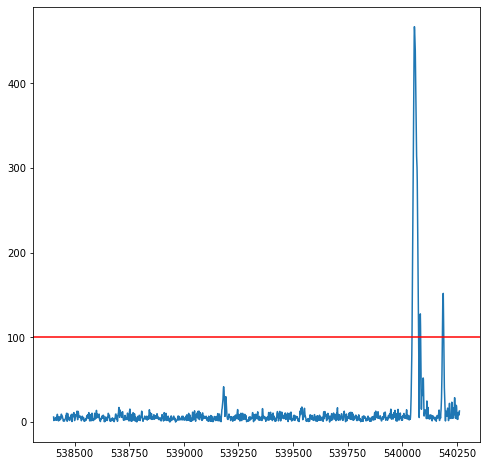

In [5]:
velocity = ivt.velocity

plt.figure(figsize=(8, 8))
plt.plot(time, velocity)
plt.axhline(y=100, color='red')
plt.show()

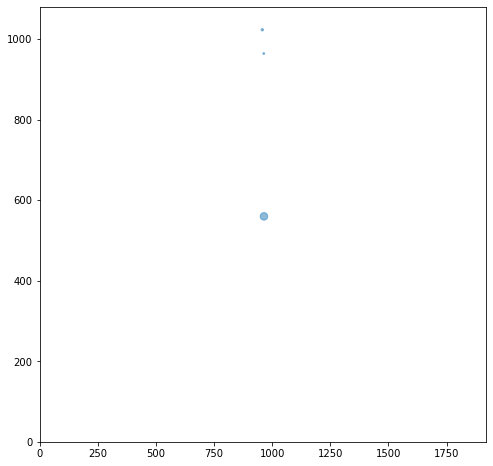

In [6]:
plt.figure(figsize=(8, 8))
plt.scatter(x=trial_summary.x_centroid,
            y=trial_summary.y_centroid,
            s=trial_summary.variance,
            alpha=0.5)
plt.xlim(0, 1920)
plt.ylim(0, 1080)
plt.show()

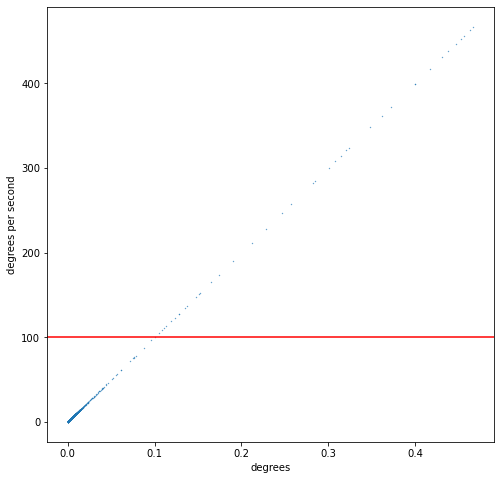

In [7]:
velocity = ivt.velocity
visual_angle = ivt.visual_angle

plt.figure(figsize=(8, 8))
plt.scatter(visual_angle, velocity, 0.1)
plt.axhline(y=100, color='red')
plt.xlabel('degrees')
plt.ylabel('degrees per second')
plt.show()

### trial by trial pipeline

In [8]:
# initialize subject parameters
ivt_subj1 = IVT(dist_to_screen=65,
                resolution=(1920, 1080),
                diagonal_inch=21)

summary_df = pd.DataFrame([])
n_trials = df.Trial.unique().tolist()
for n_trial in n_trials:
    # prepare trial data into numpy array
    index_trial = df[df.Trial.eq(n_trial)].index
    time_trial = df.loc[index_trial, "time"].values
    x_trial = df.loc[index_trial, "x"].values
    y_trial = df.loc[index_trial, "y"].values
    
    # run IVT algorythm
    ivt_subj1.identify_fixation(time=time_trial,
                                x_coord=x_trial,
                                y_coord=y_trial,
                                velocity_threshold=100,
                                duration_threshold=50)
    # get summary
    trial_summary = ivt_subj1.summary
    
    # set multi index
    tuples = [(n_trial, cl) for cl in trial_summary.index]
    index = pd.MultiIndex.from_tuples(tuples, names=("trial", "fixation"))
    trial_summary.set_index(index, inplace=True)
    # save summary trial by trial
    summary_df = pd.concat([summary_df, trial_summary])

    # save intermediate calculations
    df.loc[index_trial, "x_smoothed"] = ivt_subj1.x_smoothed
    df.loc[index_trial, "y_smoothed"] = ivt_subj1.y_smoothed
    df.loc[index_trial, "euclidean_dist"] = ivt_subj1.euclidean_dist
    df.loc[index_trial, "visual_angle"] = ivt_subj1.visual_angle
    df.loc[index_trial, "velocity"] = ivt_subj1.velocity


In [9]:
df.head(10)
# NaN is due to smoothing of moving average and calculating distances between consecutive points

,Trial,time,x,y,x_smoothed,y_smoothed,euclidean_dist,visual_angle,velocity
0,1,507289,960.2,529.8,NaN,NaN,NaN,NaN,NaN
1,1,507290,960.2,529.3,NaN,NaN,NaN,NaN,NaN
2,1,507291,960.2,528.6,NaN,NaN,NaN,NaN,NaN
3,1,507292,960.1,527.8,NaN,NaN,NaN,NaN,NaN
4,1,507293,960.3,527.2,960.20,528.54,NaN,NaN,NaN
5,1,507294,960.8,527.8,960.32,528.14,0.417612,0.008913,8.913317
6,1,507295,961.3,528.5,960.54,527.98,0.272029,0.005806,5.806066
7,1,507296,961.5,529.3,960.80,528.12,0.295296,0.006303,6.302667
8,1,507297,961.5,529.2,961.08,528.40,0.395980,0.008452,8.451604
9,1,507298,961.3,529.3,961.28,528.82,0.465188,0.009929,9.928753


In [10]:
summary_df.sample(10)

,,time_from,time_to,duration,x_centroid,y_centroid,variance,average_velocity
trial,fixation,,,,,,,
34,10.0,645767.0,645968.0,201.0,903.421485,568.301683,3.029830,10.243031
16,2.0,581480.0,581644.0,164.0,1208.896848,530.938424,3.032888,8.871929
10,1.0,558554.0,559620.0,1066.0,954.836345,527.729316,67.087410,5.630256
30,1.0,629607.0,630634.0,1027.0,945.082451,520.717140,67.717252,7.074851
23,2.0,604364.0,604545.0,181.0,1351.775495,535.284286,2.212401,7.934442
34,18.0,647580.0,647991.0,411.0,1110.727621,531.977087,2.817876,9.348844
5,1.0,538399.0,540043.0,1644.0,964.541617,559.854918,57.284099,6.037735
34,12.0,646360.0,646505.0,145.0,760.150548,533.221781,3.776316,14.482532
9,1.0,554097.0,555756.0,1659.0,955.783614,553.097386,55.189005,5.847870


In [11]:
# save results
path_to_processed_data = root / "processed"
if not path_to_processed_data.is_dir():
    path_to_processed_data.mkdir()

df.to_csv(path_to_processed_data / "data.csv", sep=";", index=False)
summary_df.to_csv(path_to_processed_data / "summary.csv", sep=";")